In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Path to your training data file
file_path = "data_dummy_BLT_DD.xlsx"

def load_and_prepare_data(file_path):
    df = pd.read_excel(file_path)

    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['Jenis Pekerjaan', 'Riwayat Penyakit Kronis', 'Tingkat Pendidikan', 'Status Kepemilikan Rumah',
                           'Kehilangan Mata Pencaharian', 'Anggota Keluarga Rentan', 'Tidak Menerima Bantuan Sosial',
                           'Rumah Tangga Lansia Tunggal', 'Perempuan Kepala Keluarga']

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Prepare features and target
    X = df.drop(columns=['Nama Keluarga', 'Alamat', 'Kabupaten', 'Kecamatan', 'Kategori'])
    y = df['Kategori'].apply(lambda x: 1 if x == 'Miskin Ekstrim' else 0)
    original_labels = df['Kategori']

    return X, y, df, original_labels

# Load and prepare data
X, y, df, original_labels = load_and_prepare_data(file_path)

# Tampilkan data yang sudah diproses
df.head()


,Nama Keluarga,Alamat,Kabupaten,Kecamatan,Pendapatan Per Bulan,Jenis Pekerjaan,Riwayat Penyakit Kronis,Tingkat Pendidikan,Status Kepemilikan Rumah,Kehilangan Mata Pencaharian,Anggota Keluarga Rentan,Tidak Menerima Bantuan Sosial,Rumah Tangga Lansia Tunggal,Perempuan Kepala Keluarga,Kategori
0,Zainal,Jl. Melati No.7,Aceh Utara,Matangkuli,600000,3,0,0,1,1,1,1,0,0,Miskin Ekstrim
1,Kartini,Jl. Dahlia No.8,Aceh Utara,Matangkuli,650000,2,1,1,0,0,1,0,1,1,Miskin Ekstrim
2,Aisyah,Jl. Kenanga No.6,Aceh Utara,Baktiya,700000,1,0,1,0,0,1,0,0,1,Miskin Ekstrim
3,Hendra,Jl. Teratai No.11,Aceh Utara,Nibong,700000,4,1,0,1,1,1,1,0,0,Miskin Ekstrim
4,Nabila,Jl. Kamboja No.16,Aceh Utara,Samudera,700000,1,0,1,0,0,0,0,1,1,Miskin Ekstrim


In [2]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan informasi pembagian data
print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))


Jumlah data latih: 16
Jumlah data uji: 4


In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tampilkan beberapa baris data yang sudah distandardisasi
print("Data latih yang sudah distandardisasi:\n", X_train_scaled[:5])
print("Data uji yang sudah distandardisasi:\n", X_test_scaled[:5])


Data latih yang sudah distandardisasi:
 [[-0.40755576  1.55194114  1.13389342 -1.13389342  1.13389342  1.29099445
  -1.29099445  1.13389342  1.4832397  -1.13389342]
 [-0.87333376 -0.8510645  -0.8819171   0.8819171  -0.8819171  -0.77459667
   0.77459667 -0.8819171   1.4832397   0.8819171 ]
 [-0.17466675 -0.8510645  -0.8819171   0.8819171  -0.8819171  -0.77459667
  -1.29099445 -0.8819171  -0.67419986  0.8819171 ]
 [-0.87333376  1.55194114  1.13389342 -1.13389342  1.13389342  1.29099445
   0.77459667  1.13389342 -0.67419986 -1.13389342]
 [ 1.45555627  1.55194114  1.13389342 -1.13389342  1.13389342  1.29099445
   0.77459667  1.13389342 -0.67419986 -1.13389342]]
Data uji yang sudah distandardisasi:
 [[-1.33911177  0.75093926 -0.8819171  -1.13389342  1.13389342  1.29099445
   0.77459667  1.13389342 -0.67419986 -1.13389342]
 [ 1.45555627 -1.65206638  1.13389342 -1.13389342  1.13389342  1.29099445
   0.77459667  1.13389342 -0.67419986 -1.13389342]
 [ 0.52400026 -1.65206638  1.13389342 -1.13389

In [4]:
from sklearn.svm import SVC

def train_svm(X_train, y_train, kernel='linear'):
    model = SVC(kernel=kernel, verbose=True)
    model.fit(X_train, y_train)
    return model

# Train SVM model
model = train_svm(X_train_scaled, y_train)

# Tampilkan parameter model
print("Parameter model:\n", model.get_params())


[LibSVM]Parameter model:
 {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}


In [5]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    classification_rep = classification_report(y_test, model.predict(X_test))
    return train_accuracy, test_accuracy, classification_rep

# Evaluate the model
train_accuracy, test_accuracy, classification_rep = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

# Tampilkan hasil evaluasi
print("Akurasi pelatihan:", train_accuracy)
print("Akurasi pengujian:", test_accuracy)
print("Laporan klasifikasi:\n", classification_rep)


Akurasi pelatihan: 1.0
Akurasi pengujian: 0.75
Laporan klasifikasi:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



In [6]:
import joblib

def save_model(model, scaler, model_path='svm_model.pkl', scaler_path='scaler.pkl'):
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)

# Save the model and scaler
save_model(model, scaler)
print("Model dan scaler telah disimpan.")


Model dan scaler telah disimpan.


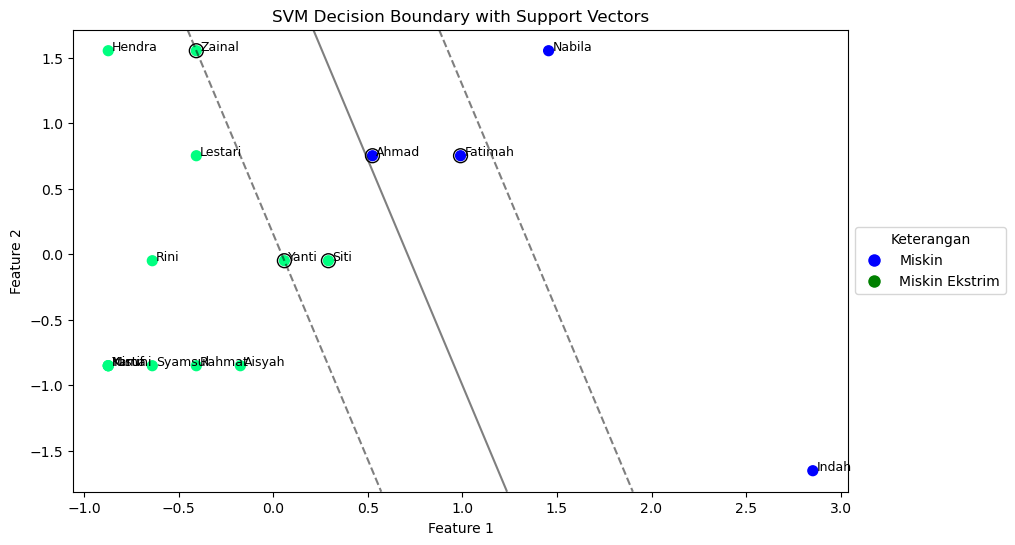

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_hyperplane(X_train, y_train, model, df):
    plt.figure(figsize=(10, 6))

    # Reduce to 2D for visualization
    X_train_2d = X_train[:, :2]
    model_2d = SVC(kernel='linear')
    model_2d.fit(X_train_2d, y_train)

    # Plot the points
    scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='winter', s=50)

    # Add annotations
    for i, (x, y) in enumerate(X_train_2d):
        plt.text(x + 0.02, y, df.iloc[i]["Nama Keluarga"], fontsize=9, ha='left')  # offset the text a bit

    # Plot the decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model_2d.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    ax.scatter(model_2d.support_vectors_[:, 0], model_2d.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

    plt.title('SVM Decision Boundary with Support Vectors')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Add legend for colors outside the plot
    colors = {0: 'blue', 1: 'green'}
    labels = {0: 'Miskin', 1: 'Miskin Ekstrim'}

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
    plt.legend(handles, labels.values(), title="Keterangan", loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

# Visualize the decision boundary
visualize_hyperplane(X_train_scaled, y_train, model, df)


In [ ]:
from tabulate import tabulate

def output_svm_values(X_train, y_train, df, original_labels, model):
    decision_values = model.decision_function(X_train)
    df_train = df.iloc[:len(X_train)].copy()  # Ensure correct subset
    df_train['SVM Value'] = decision_values
    df_train['Label'] = original_labels.iloc[:len(X_train)]  # Use original labels
    output_df = df_train[['Nama Keluarga', 'SVM Value', 'Label']]
    print(tabulate(output_df, headers='keys', tablefmt='psql'))
    return output_df

# Output SVM values
output_df = output_svm_values(X_train_scaled, y_train, df, original_labels, model)
output_df
